# Normalization of simultaneously recorded Ca transients from pxp files
#### Marco Arieli Herrera-Valdez, Ana Itzel Aquiles-Reyes
#### Facultad de Ciencias, Universidad Nacional Autónoma de México


Data contained in .pxp files is extracted using a python module called _igor.py_ (https://github.com/wking/igor). 
The data is filtered to remove noise and graphed for superficial exploration and normalized with different normalizations for comparison. 

As before,  all the auxiliary files necessary to run the code below can be found in _transientPreAnalysis.py_
All the data files are assumed to be in the local directory called _hipophysis_.

In [8]:
from transientPreAnalysis import * 
%matplotlib inline

Now let us build a function that extracts all the data contained in a .pxp file within a given directory, 
smooths the data and normalizes all amplitudes in different ways. Notice the function has flags that allow different normalizations.

In [18]:
def getSmoothAllPXPData(dirName,fName,hiCut=40, norm01=0,shift0=0,shift0Max=1):
	# Read the data from one file
	print("Extracting data from file %s"%(dirName+fName))
	fMinData,sampTimes=extractDebleachedFminData(dirName+fName)
	# Calculate all the areas under the curves before normalization
	areas=fMinData.cumsum(1)[:,-1]
	# Look for cells that may have faulty data 
	goodCells=sc.where(sc.isnan(areas)==False)[0]
	areas= areas[goodCells]
	# Keep the good data
	transCa=fMinData[goodCells]
	# Count cells and frames
	nCells,nFrames= transCa.shape
	# Smooth the signals
	smoothCa= sc.zeros(fMinData.shape)
	smoothCa01= sc.zeros(fMinData.shape)
	smoothCa0= sc.zeros(fMinData.shape)
	smoothCa0Max= sc.zeros(fMinData.shape)
	for n in sc.arange(nCells):
		smoothCa[n]=lowHighCutFreqSmoothing(transCa[n], lowCut=0, hiCut=hiCut)
		if norm01:
			smoothCa01[n]= (smoothCa[n] - smoothCa[n].min())/(smoothCa[n].max() - smoothCa[n].min())
		if shift0:
			smoothCa0[n]= (smoothCa[n] - smoothCa[n].min())
	mCa=smoothCa.min()
	MCa=smoothCa.max()
	for n in sc.arange(nCells):
		if shift0Max:
			smoothCa0Max[n]= (smoothCa[n] - mCa)/(MCa - mCa)
	data={"smoothCa": smoothCa, "transCa": transCa, 
		"fName":fName, "nCells": nCells,
		"sampTimes":sampTimes, "areas":areas}
	if norm01:
		data["smoothCa01"]=smoothCa01
	if shift0:
		data["smoothCa0"]=smoothCa0
	if shift0Max:
		data["smoothCa0Max"]=smoothCa0Max
	return data

Example of use of the function for two data sets

In [22]:
dirName="./hipophysis/"
pericitosBasal= getSmoothAllPXPData(dirName=dirName, fName="FminBasalPericitos.pxp",hiCut=40, norm01=1,shift0=1,shift0Max=1)
endocrinasBasal= getSmoothAllPXPData(dirName=dirName, fName="FminBasalEndocrinas.pxp",hiCut=40, norm01=1,shift0=1,shift0Max=1)

Extracting data from file ./hipophysis/FminBasalPericitos.pxp
Extracting data from file ./hipophysis/FminBasalEndocrinas.pxp


Plot all the data for check and compare the normalizations
\begin{eqnarray}
y_n &=& \frac{x_n - \min(x_n)}{\max(x_n)- \min(x_n)}, \quad n \in  \left\{1,...,N \right\}
 \\
y_n &=& {x_n - \min(x_n)}, \quad n \in  \left\{1,...,N \right\}
 \\
y &=& \frac{x - \min(x)}{\max(x)- \min(x)}
\end{eqnarray}
where $x = (x_n:  n =1,...,N )$ is the recording from all cells, $x_n$ is the $n$th cell time series, and the $\min$ and $\max$ in the last equations are the global minimum and maximum calculated for all cells in the recordings. 

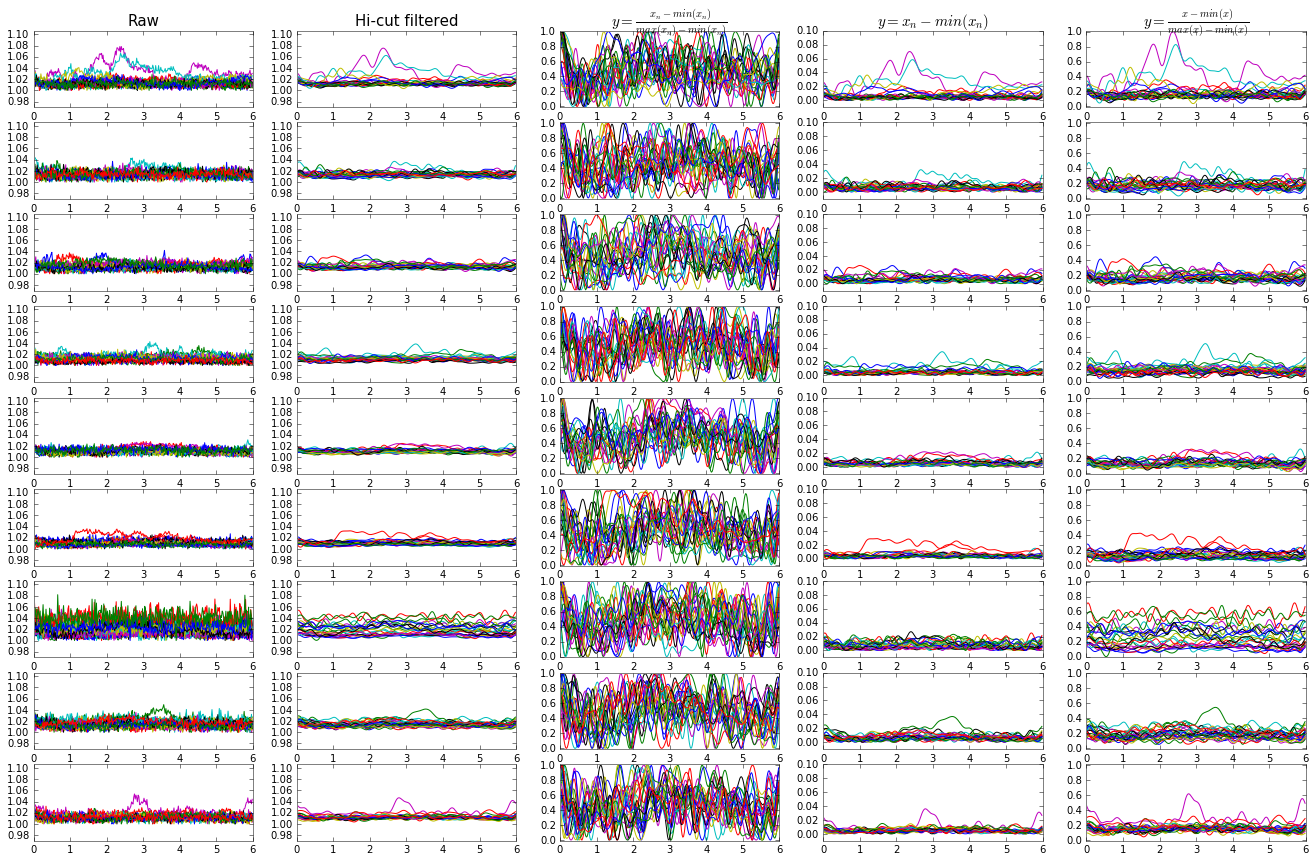

In [29]:
#recs=pericitosBasal
recs=endocrinasBasal
nCells=recs["nCells"]
nPieces=9; q= nCells/nPieces
fig= gr.figure(figsize=(19, 15));
fig.canvas.set_window_title("%s"%(recs["fName"]))
gr.ioff(); r=nPieces; c=5; 
ax1=list(); ax2=list(); ax3=list(); ax4=list(); ax5=list()
for m in sc.arange(nPieces):
	ax1.append(fig.add_subplot(r,c,m*c +1))
	ax2.append(fig.add_subplot(r,c,m*c +2))
	ax3.append(fig.add_subplot(r,c,m*c +3))
	ax4.append(fig.add_subplot(r,c,m*c +4))
	ax5.append(fig.add_subplot(r,c,m*c +5))
ax1[0].set_title("Raw",fontsize=15)
ax2[0].set_title("Hi-cut filtered",fontsize=15)
ax3[0].set_title(r"$y= \frac{x_n - min(x_n)}{max(x_n)-min(x_n)} $",fontsize=15)
ax4[0].set_title(r"$y={x_n - min(x_n)} $",fontsize=15)
ax5[0].set_title(r"$y= \frac{x - min(x)}{max(x)-min(x)} $",fontsize=15)
for m in sc.arange(nPieces):
	a= sc.int32(m * q)
	b= sc.int32(sc.minimum(((m+1) * q), nCells))
	dd = recs["transCa"][a:b]
	ff = recs["smoothCa"][a:b]
	gg = recs["smoothCa01"][a:b]
	hh = recs["smoothCa0"][a:b]
	ii = recs["smoothCa0Max"][a:b]
	#print(len(recs["sampTimes"]),len(dd[n]))
	for n in sc.arange(len(dd)):
		ax1[m].plot(recs["sampTimes"], dd[n])
		ax2[m].plot(recs["sampTimes"], ff[n])
		ax3[m].plot(recs["sampTimes"], gg[n])
		ax4[m].plot(recs["sampTimes"], hh[n])
		ax5[m].plot(recs["sampTimes"], ii[n])

	ax1[m].set_ylim(recs["transCa"].min()*0.97, recs["transCa"].max()*1.01)
	ax2[m].set_ylim(recs["transCa"].min()*0.97, recs["transCa"].max()*1.01)
	ax3[m].set_ylim(-0.01, 1.01)
	ax4[m].set_ylim(-0.01, 0.1)
	ax5[m].set_ylim(-0.01, 1.01)

ax1[0].set_xlabel("secs",fontsize=15)
ax2[0].set_xlabel("secs",fontsize=15)
ax3[0].set_xlabel("secs",fontsize=15)
ax4[0].set_xlabel("secs",fontsize=15)
ax5[0].set_xlabel("secs",fontsize=15)
fig.subplots_adjust(left=0.05, right=0.98, top=0.85, bottom=0.1)
gr.ion(); gr.draw()

The best normalization is
\begin{equation}
y = \frac{x - \min(x)}{\max(x)-\min(x)}
\end{equation}
shown on the right.